<a href="https://colab.research.google.com/github/DhanaSrivalli/21087223/blob/main/21087223_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Using pip, install the required packages
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is i

In [ ]:
# Import necessary libraries
from datasets import load_dataset, DatasetDict
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from sklearn.metrics import accuracy_score
from transformers import EvalPrediction
import matplotlib.pyplot as plt
import torch

In [ ]:
# Load the entire Hugging Face Datasets dataset
dataset_dictionary = load_dataset("jahjinx/IMDb_movie_reviews")

# Use a function to take a 15% dataset sample.
def sample_15_percent(dataset):
    sampling_size = int(0.15 * len(dataset))
    return dataset.shuffle(seed=42).select(range(sampling_size))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/36000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Take 15% of each split to create a dictionary of the smaller dataset.
reduced_dataset_dict = {
    split: sample_15_percent(dataset)
    for split, dataset in dataset_dictionary.items()
}
reduced_dataset_dict

{'train': Dataset({
     features: ['text', 'label'],
     num_rows: 5400
 }),
 'validation': Dataset({
     features: ['text', 'label'],
     num_rows: 600
 }),
 'test': Dataset({
     features: ['text', 'label'],
     num_rows: 1500
 })}

In [ ]:
# To make processing easier, Converting the smaller dataset into a DatasetDict
last_dataset = DatasetDict({
    split: dataset for split, dataset in reduced_dataset_dict.items()
})

In [ ]:
# Setting up the model and tokenizer
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(dataset):
    return tokenizer_bert(dataset['text'], truncation=True, padding='max_length', max_length=256)# adjust the length according if necessary
tokenized_datasets = last_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
# Create a function to format the dataset's labels.
def format_labels(dataset):
    dataset['text'] = int(dataset['label'])
    return dataset

In [ ]:
#Tokenizing the datasets and using the label formatting function
tokenized_datasets = tokenized_datasets.map(format_labels)

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
#loading the bert model that has been previously trained using the 'bert-base' dataset
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up training arguments
instruction_args = TrainingArguments(
    output_dir='./results',            # Directory for saving results
    eval_strategy='epoch',       # Perform evaluation at the end of each epoch
    learning_rate=5e-5,                # Learning rate
    per_device_train_batch_size=4,     # Training batch size per device
    num_train_epochs=10,               # Number of training epochs
    weight_decay=0.01,                 # Weight decay
    save_strategy="epoch",             # Save the model at the end of each epoch
    logging_dir='./logs',              # Directory for storing logs
    logging_strategy='steps',          # Log training loss every logging step
    logging_steps=10,                  # Log training loss every 10 steps
    report_to="all"                    # Report logs to all configured handlers
)

In [ ]:
# Creating a LossLoggingCallback class to record validation and training losses for display

class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Type errors can be avoided by using kwargs to catch unexpected keyword arguments.
        # Training loss resulting from training logs
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        # Logs' validation loss during evaluation
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

In [ ]:
# Function to calculate the model's prediction accuracy
def model_metrics(pred: EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [ ]:
# Set up the callback
loss_logging_callback = LossLoggingCallback()

In [ ]:
# Setting up the model, training arguments, datasets for training and testing, metrics, and callbacks in the trainer
trainer = Trainer(
    model=model,
    args=instruction_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=model_metrics,
    callbacks=[loss_logging_callback]
)

In [ ]:
# Utilizing the Gpu memory for fast trining
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Start model training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.677400,0.726991,0.801667
2,0.656400,0.395308,0.896667
3,0.238000,0.671827,0.871667
4,0.106700,0.709665,0.866667
5,0.000200,0.752866,0.886667
6,0.000400,0.959973,0.883333
7,0.000100,1.312758,0.853333
8,0.000000,1.089719,0.873333
9,0.000000,1.077305,0.885000
10,0.000000,1.040145,0.890000


TrainOutput(global_step=13500, training_loss=0.14033382439637057, metrics={'train_runtime': 3070.6817, 'train_samples_per_second': 17.586, 'train_steps_per_second': 4.396, 'total_flos': 7103998494720000.0, 'train_loss': 0.14033382439637057, 'epoch': 10.0})

In [ ]:
# After training is finished, assess the model on the validation set.
trainer.evaluate()

{'eval_loss': 1.0401448011398315,
 'eval_accuracy': 0.89,
 'eval_runtime': 8.8427,
 'eval_samples_per_second': 67.852,
 'eval_steps_per_second': 8.482,
 'epoch': 10.0}

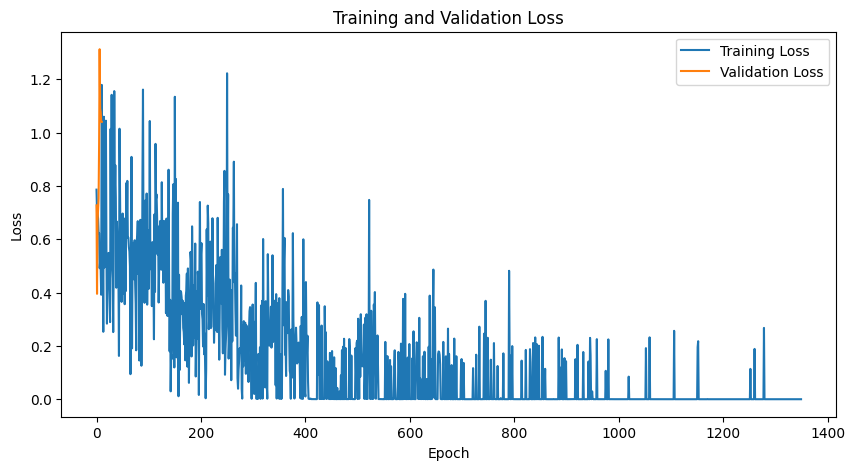

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(loss_logging_callback.train_losses, label='Training Loss')
plt.plot(loss_logging_callback.eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()